### Reference Links
1. https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216
2. https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199
3. https://github.com/walid0925/AI_Artistry/blob/master/main.py
4. https://markojerkic.com/style-transfer-keras/

### Import packages

In [216]:
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.applications.vgg16 import preprocess_input ## Pretrained Model
from keras.preprocessing.image import load_img, img_to_array

from keras.applications import VGG16
from scipy.optimize import fmin_l_bfgs_b

from PIL import Image

### Image File Path
Input image path:
1. Content image path
2. Style image path

In [152]:
content_image_path = 'image_data/cat.jpg'
style_image_path = 'image_data/violin_and_palette.jpeg'

### targetSize

In [153]:
target_height = 512
target_width = 512
target_size = (target_height, target_width)
target_size

(512, 512)

### Load Image

In [154]:
def show_image(file_path, img_type=None):
    print "img_type: ", img_type
    return load_img(path=file_path, target_size=target_size)

img_type:  Content


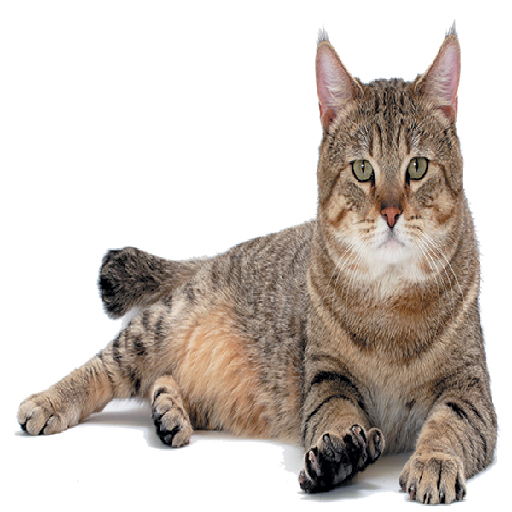

In [155]:
show_image(content_image_path, img_type="Content")

img_type:  Style


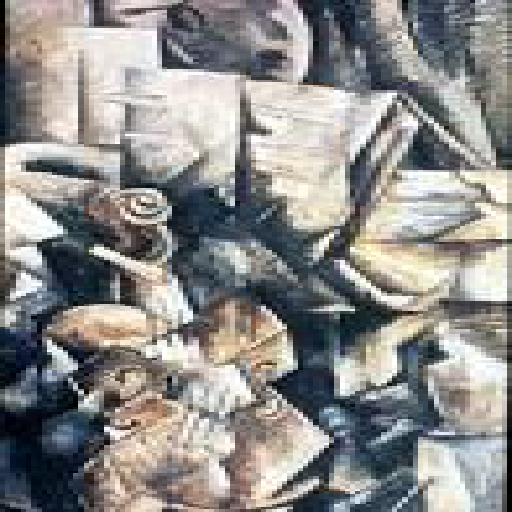

In [156]:
show_image(style_image_path, img_type="Style")

In [157]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
        plt.imshow(out)

In [158]:
def show_content_and_style_image(content_image_path, style_image_path):
    plt.figure(figsize=(5,5))
    content = load_img(content_image_path)
    style = load_img(style_image_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    plt.show()

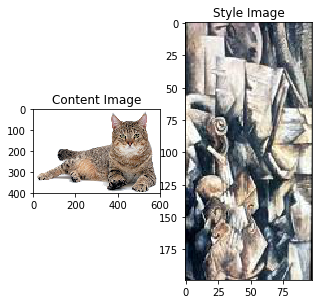

In [159]:
show_content_and_style_image(content_image_path, style_image_path)

In [160]:
def get_image_arr(file_path):
    image = load_img(path=file_path, target_size=target_size)
    image_arr = img_to_array(image)
    return image_arr, K.variable(preprocess_input(np.expand_dims(image_arr, axis=0)), dtype='float32')

In [161]:
_, c_img_arr = get_image_arr(content_image_path)
_, s_img_arr = get_image_arr(style_image_path)

In [162]:
print c_img_arr
print s_img_arr

<tf.Variable 'Variable_15:0' shape=(1, 512, 512, 3) dtype=float32_ref>
<tf.Variable 'Variable_16:0' shape=(1, 512, 512, 3) dtype=float32_ref>


In [163]:
def initilize_generated_img():
    g_img = np.random.randint(256, size=(target_width, target_height, 3)).astype('float64')
    g_img = preprocess_input(np.expand_dims(g_img, axis=0))
    return g_img

In [164]:
g_img_placeholder = K.placeholder(shape=(1, target_width, target_height, 3))

In [165]:
g_img_placeholder

<tf.Tensor 'Placeholder_236:0' shape=(1, 512, 512, 3) dtype=float32>

### get feature reprrsentation

In [188]:
def get_feature_reps(x, model, layer_names):
    """
    Get feature representations of input x for one or more layers in a given model.
    """
    feat_matrices = []
    for ln in layer_names:
        selected_layer = model.get_layer(ln)
        feat_raw = selected_layer.output
        feat_raw_shape = K.shape(feat_raw).eval(session=tf_session)
        N_l = feat_raw_shape[-1]
        M_l = feat_raw_shape[1]*feat_raw_shape[2]
        feat_matrix = K.reshape(feat_raw, (M_l, N_l))
        feat_matrix = K.transpose(feat_matrix)
        feat_matrices.append(feat_matrix)
    return feat_matrices

### Content Loss

In [189]:
def get_content_loss(F, P):
    c_loss = 0.5*K.sum(K.square(F - P))
    return c_loss

### gram_matrix

In [190]:
def get_gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

### Style Loss
paramters:
    1. ws
    2. gs
    3. as
steps:
     1. Calculate gram matrix for genrated image
     2. Calculate gram matrix for style image
     3. Calculate loss

In [191]:
def get_style_loss(ws, Gs, As):
    s_loss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_gram_matrix(G)
        A_gram = get_gram_matrix(A)
        s_loss+= w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return s_loss

### Calculate Total Loss
Parameters: 
    1. alpha
    2. beta
Steps:
    1. Get feature reprrsentation of generated image for content image layer
    2. Get feature reprrsentation of generated image for style image layer
    3. get_content_loss
    4. get_style_loss
    5. total_loss: alpha*content_loss + beta*style_loss
    

In [192]:
def get_total_loss(g_img_placeholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(g_img_placeholder, model=g_model, layer_names=[c_layer_name])[0]
    Gs = get_feature_reps(g_img_placeholder, model=g_model, layer_names=s_layer_names)
    content_loss = get_content_loss(F, P)
    style_loss = get_style_loss(ws, Gs, As)
    total_loss = alpha*content_loss + beta*style_loss
    return total_loss

In [193]:
def calculate_loss(g_img_arr):
    if g_img_arr.shape != (1, target_width, target_width, 3):
        g_img_arr = g_img_arr.reshape((1, target_width, target_height, 3))
    loss_fcn = K.function([g_model.input], [get_total_loss(g_model.input)])
    return loss_fcn([g_img_arr])[0].astype('float64')

### Calculate Gradient of loss function respect to the generated image
paramters:
    1. g_img_arr

In [194]:
def get_grad(g_img_arr):
    """
      Calculate the gradient of the loss function with respect to the generated image
    """
    if g_img_arr.shape != (1, target_width, target_height, 3):
        gImArr = g_img_arr.reshape((1, target_width, target_height, 3))
    grad_fcn = K.function([g_model.input], 
                          K.gradients(get_total_loss(g_model.input), [g_model.input]))
    grad = grad_fcn([g_img_arr])[0].flatten().astype('float64')
    return grad

In [195]:
tf_session = K.get_session()

In [174]:
def get_model(input_tensor, include_top=False, weights="imagenet"):
    return VGG16(include_top=include_top, weights=weights, input_tensor=input_tensor)

In [196]:
c_model = get_model(input_tensor=c_img_arr)
s_model = get_model(input_tensor=s_img_arr)
g_model = get_model(input_tensor=g_img_placeholder)

### Layer Parameter:
1. c_layer_name
2. s_layer_names

In [197]:
c_layer_name = 'block4_conv2'
s_layer_names = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                ]

In [198]:
g_img = initilize_generated_img()

In [178]:
# g_img

In [199]:
P = get_feature_reps(x=c_img_arr, model=c_model, layer_names=[c_layer_name])[0]
As = get_feature_reps(x=s_img_arr, model=s_model, layer_names=s_layer_names)
ws = np.ones(len(s_layer_names))/float(len(s_layer_names))

In [200]:
np.ones(len(s_layer_names))

array([1., 1., 1., 1.])

In [201]:
print "P: ", P
print "As: ", As
print "ws: ", ws

P:  Tensor("transpose_129:0", shape=(512, 4096), dtype=float32)
As:  [<tf.Tensor 'transpose_130:0' shape=(64, 262144) dtype=float32>, <tf.Tensor 'transpose_131:0' shape=(128, 65536) dtype=float32>, <tf.Tensor 'transpose_132:0' shape=(256, 16384) dtype=float32>, <tf.Tensor 'transpose_133:0' shape=(512, 4096) dtype=float32>]
ws:  [0.25 0.25 0.25 0.25]


In [202]:
512*512

262144

In [204]:
x_val.shape
# g_img.shape

(786432,)

In [227]:
iterations = 1
x_val = g_img.flatten()
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, g_img, fprime=get_grad, maxiter=iterations, disp=True)

ValueError: Cannot feed value of shape (786432,) for Tensor u'Placeholder_236:0', which has shape '(1, 512, 512, 3)'

In [211]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (target_width, target_height, 3):
        x = x.reshape((target_width, target_height, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x


In [221]:
c_image_orig = Image.open(content_image_path)
c_image_size_orig = c_image_orig.size

In [222]:
def reprocess_array(x):
    x = np.expand_dims(x.astype('float64'), axis=0)
    x = preprocess_input(x)
    return x

In [223]:
def save_original_size(x, target_size=c_image_size_orig):
    x_img = Image.fromarray(x)
    x_img = x_im.resize(target_size)
    x_img.save(gen_img_output_path)
    return x_img

In [ ]:
x_out = postprocess_array(xopt)
x_img = save_original_size(xopt)
print 'Image saved'
end = time.time()
print 'Time taken: {}'.format(end-start)